In [1]:
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import gc
import matplotlib.pyplot as plt
import os

In [2]:
def do_count( df, group_cols, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Aggregating by ", group_cols , '...' )
    gp = df[group_cols][group_cols].groupby(group_cols).size().rename(agg_name).to_frame().reset_index()
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_countuniq( df, group_cols, counted, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Counting unqiue ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].nunique().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )
    
def do_cumcount( df, group_cols, counted, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Cumulative count by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].cumcount()
    df[agg_name]=gp.values
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_mean( df, group_cols, counted, agg_name, agg_type='float32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Calculating mean of ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].mean().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_var( df, group_cols, counted, agg_name, agg_type='float32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Calculating variance of ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].var().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

In [3]:
def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', objective='binary', metrics='auc',
                 feval=None, early_stopping_rounds=20, num_boost_round=3000, verbose_eval=10, categorical_features=None):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': objective,
        'metric':metrics,
        'learning_rate': 0.2,
        #'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 10,
        'verbose': 0,
        'metric':metrics
    }

    lgb_params.update(params)

    print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )

    evals_results = {}

    bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[xgtrain, xgvalid], 
                     valid_names=['train','valid'], 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=20, 
                     feval=feval)

    print("\nModel Report")
    print("bst1.best_iteration: ", bst1.best_iteration)
    print(metrics+":", evals_results['valid'][metrics][bst1.best_iteration-1])

    return (bst1,bst1.best_iteration)


In [4]:
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32',
        }

print('loading train data...')
train_df = pd.read_csv("./train.csv.zip",compression='zip',parse_dates=['click_time'], dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'])

print('loading test data...')

test_df = pd.read_csv("./test.csv.zip", compression='zip',parse_dates=['click_time'], dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])

len_train = len(train_df)
train_df=train_df.append(test_df)
del test_df
gc.collect()

loading train data...
loading test data...


14

In [5]:
train_df.head()

,app,channel,click_id,click_time,device,ip,is_attributed,os
0,3,379,NaN,2017-11-06 14:32:21,1,83230,0.0,13
1,3,379,NaN,2017-11-06 14:33:34,1,17357,0.0,19
2,3,379,NaN,2017-11-06 14:34:12,1,35810,0.0,13
3,14,478,NaN,2017-11-06 14:34:52,1,45745,0.0,13
4,3,379,NaN,2017-11-06 14:35:08,1,161007,0.0,13


# FE

In [6]:
print('Extracting new features...')

train_df['hour'] = pd.to_datetime(train_df.click_time).dt.hour.astype('uint8');gc.collect()
train_df['day'] = pd.to_datetime(train_df.click_time).dt.day.astype('uint8');gc.collect()

train_df['click_time'] = (train_df['click_time'].astype(np.int64) // 10 ** 9).astype(np.int32)
train_df['nextClick'] = (train_df.groupby(['ip', 'app', 'device', 'os']).click_time.shift(-1) - train_df.click_time).astype(np.float32)
train_df.drop(['click_time'],axis=1,inplace=True)
train_df = do_cumcount( train_df, ['ip', 'device', 'os','app'], 'channel', 'V_1', show_max=True ); gc.collect()
train_df = do_cumcount( train_df, ['ip', 'device', 'os','channel'], 'app', 'V_2', show_max=True ); gc.collect()
# to do ip channel count unique
train_df = do_countuniq( train_df, ['app'], 'channel', 'V_3', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['channel'], 'app', 'V_4', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip','app','day'], 'os', 'V_5', 'uint8', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip', 'day','hour','app'], 'channel', 'V_6', 'uint8', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip'], 'app', 'V_7', 'uint8', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip', 'app'], 'os', 'V_8', 'uint8', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip'], 'device', 'V_9', 'uint16', show_max=True ); gc.collect()

train_df = do_count( train_df, ['ip', 'day', 'hour'], 'V_10', show_max=True ); gc.collect()
train_df = do_count( train_df, ['ip', 'app'], 'V_11', show_max=True ); gc.collect()
train_df = do_count( train_df, ['ip', 'app', 'os'], 'V_12', 'uint16', show_max=True ); gc.collect()

train_df = do_var( train_df, ['ip', 'day','os'],'channel' , 'V_13', show_max=True ); gc.collect()
train_df = do_var( train_df, ['ip', 'day', 'os'], 'app' , 'V_14', show_max=True ); gc.collect()
train_df.drop(['ip'],axis=1,inplace=True)

Extracting new features...
Cumulative count by  ['ip', 'device', 'os', 'app'] ...
V_1 max value =  50066
Cumulative count by  ['ip', 'device', 'os', 'channel'] ...
V_2 max value =  23230
Counting unqiue  channel  by  ['app'] ...
V_3 max value =  49
Counting unqiue  app  by  ['channel'] ...
V_4 max value =  305
Counting unqiue  os  by  ['ip', 'app', 'day'] ...
V_5 max value =  116
Counting unqiue  channel  by  ['ip', 'day', 'hour', 'app'] ...
V_6 max value =  30
Counting unqiue  app  by  ['ip'] ...
V_7 max value =  277
Counting unqiue  os  by  ['ip', 'app'] ...
V_8 max value =  148
Counting unqiue  device  by  ['ip'] ...
V_9 max value =  551
Aggregating by  ['ip', 'day', 'hour'] ...
V_10 max value =  44259
Aggregating by  ['ip', 'app'] ...
V_11 max value =  220743
Aggregating by  ['ip', 'app', 'os'] ...
V_12 max value =  55159
Calculating variance of  channel  by  ['ip', 'day', 'os'] ...
V_13 max value =  122512.5
Calculating variance of  app  by  ['ip', 'day', 'os'] ...
V_14 max value 

In [ ]:
train_df.head()

In [7]:
test_df = train_df[len_train:]
val_size=40000000
val_df = train_df[(len_train-val_size):len_train]
train_df = train_df[:(len_train-val_size)]
print("train size: ", len(train_df))
print("valid size: ", len(val_df))
print("test size : ", len(test_df))

sub = pd.DataFrame()
sub['click_id'] = test_df['click_id'].astype('int')

gc.collect()
target = 'is_attributed'
predictors = list(set(train_df.columns) - set(['is_attributed','click_id'])) 
categorical = ['app', 'device', 'os', 'channel', 'hour', 'day']
print('predictors',predictors)

train size:  144903890
valid size:  40000000
test size :  18790469
predictors ['day', 'app', 'channel', 'device', 'V_2', 'V_14', 'V_7', 'hour', 'V_4', 'V_13', 'V_8', 'V_5', 'V_3', 'V_6', 'nextClick', 'V_12', 'V_9', 'V_11', 'V_10', 'V_1', 'os']


Training...
preparing validation datasets
Train until valid scores didn't improve in 50 rounds.
[20]	train's auc: 0.975552	valid's auc: 0.969479
[40]	train's auc: 0.980731	valid's auc: 0.976267
[60]	train's auc: 0.982402	valid's auc: 0.978309
[80]	train's auc: 0.983249	valid's auc: 0.979255
[100]	train's auc: 0.983837	valid's auc: 0.980049
[120]	train's auc: 0.984372	valid's auc: 0.980637
[140]	train's auc: 0.984648	valid's auc: 0.980919
[160]	train's auc: 0.98488	valid's auc: 0.981148
[180]	train's auc: 0.985075	valid's auc: 0.981367
[200]	train's auc: 0.985243	valid's auc: 0.981584
[220]	train's auc: 0.985379	valid's auc: 0.981672
[240]	train's auc: 0.985499	valid's auc: 0.981777
[260]	train's auc: 0.985619	valid's auc: 0.981865
[280]	train's auc: 0.985711	valid's auc: 0.981896
[300]	train's auc: 0.9858	valid's auc: 0.981908
[320]	train's auc: 0.985912	valid's auc: 0.982063
[340]	train's auc: 0.985988	valid's auc: 0.982116
[360]	train's auc: 0.986098	valid's auc: 0.982224
[380]	train

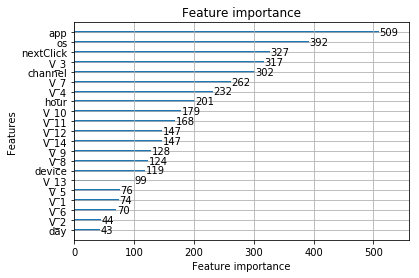

Predicting...
writing...
done...


In [8]:
print("Training...")
start_time = time.time()

params = {
    'learning_rate': 0.2,
    #'is_unbalance': 'true', # replaced with scale_pos_weight argument
    'num_leaves': 12,  # 2^max_depth - 1
    'max_depth': 5,  # -1 means no limit
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100,  # Number of bucketed bin for feature values
    'subsample': 0.95,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'scale_pos_weight':130 # because training data is extremely unbalanced 
}
(bst,best_iteration) = lgb_modelfit_nocv(params, 
                        train_df, 
                        val_df, 
                        predictors, 
                        target, 
                        objective='binary', 
                        metrics='auc',
                        early_stopping_rounds=50, 
                        verbose_eval=True, 
                        num_boost_round=500, 
                        categorical_features=categorical)

print('[{}]: model training time'.format(time.time() - start_time))
del train_df
del val_df
gc.collect()


print('Plot feature importances...')
ax = lgb.plot_importance(bst, max_num_features=100)
plt.show()

print("Predicting...")
sub['is_attributed'] = bst.predict(test_df[predictors],num_iteration=best_iteration)

print("writing...")
sub.to_csv('sub_version_FE.csv',index=False,float_format='%.9f')
print("done...")


In [ ]:
'''Model Report
bst1.best_iteration:  360
auc: 0.9822240972346243
PB 0.9775'''

In [2]:
0.9822-0.9775

0.0046999999999999265